In [1]:
# Let's make a rotator distribution where we just pick a rotation angle to maintain each night. See if that results in something better

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
np.random.seed(42)

In [14]:
#runName = 'astro-lsst-01-2013'
conn = db.OpsimDatabase('astro-lsst-01_2013.db')
#conn  = db.Database('feature_baseline_10yrs.db', defaultTable='observations')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [15]:
bundleList = []

metric = metrics.RmsAngleMetric(col='rotSkyPos')
slicer = slicers.HealpixSlicer(nside=64)
sql = 'filter ="i"'

bundle = metricBundles.MetricBundle(metric, slicer, sql)
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))

metric=metrics.MeanAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter ="i" for columns ['observationStartLST', 'fieldRA', 'rotTelPos', 'observationStartMJD', 'night', 'fieldDec']
Found 505407 visits
Running:  ['opsim_RmsAngle_rotSkyPos_i_HEAL', 'opsim_FullRangeAngle_rotSkyPos_i_HEAL', 'opsim_MeanAngle_rotSkyPos_i_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:119: UserWarning: Warning - column rotTelPos already present in simData, may be overwritten (depending on stacker).
  % (col))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="i"" constraint now.
monopole: 55.5471  dipole: lon: -54.3317, lat: -57.8597, amp: 7.09028
monopole: 223.636  dipole: lon: -75.0187, lat: -73.8307, amp: 43.514
monopole: 189.088  dipole: lon: 135.036, lat: -36.2688, amp: 62.8685
Plotting complete.


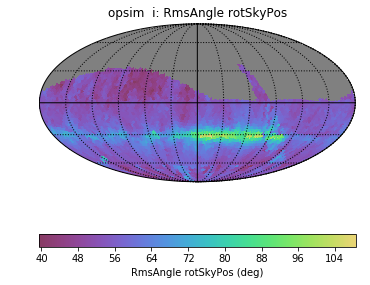

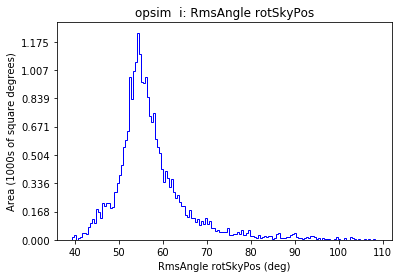

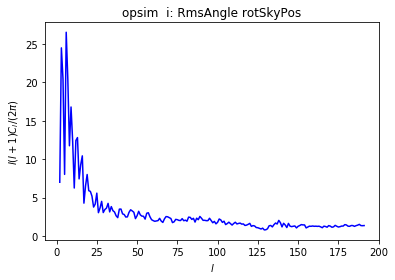

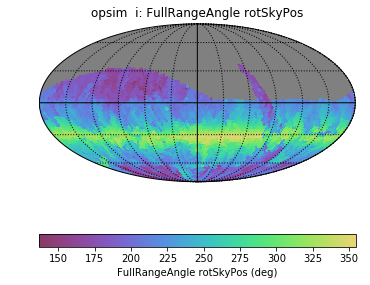

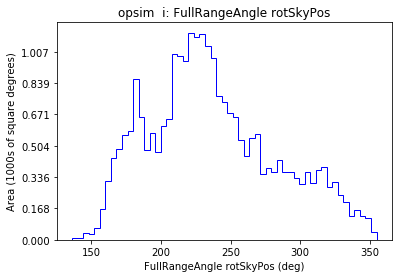

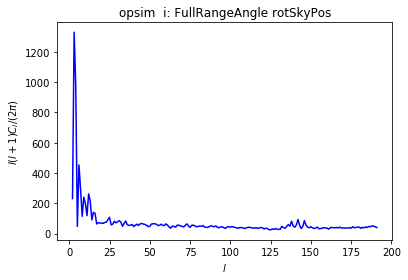

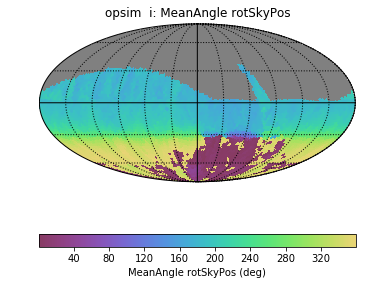

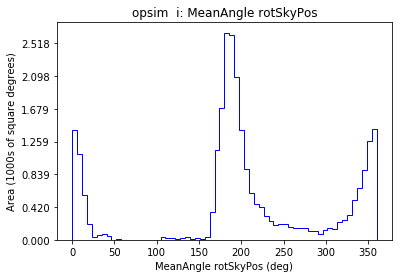

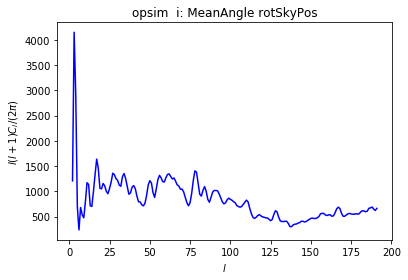

In [16]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [3]:
# Now to make a new stacker that randomizes rotSkyPos per night, and then recalc the rotTelPos
class RandRotSkyPos(stackers.BaseStacker):
    def __init__(self, raCol='fieldRA', decCol='fieldDec', degrees=True, mjdCol='observationStartMJD',
                 lstCol='observationStartLST', rotTelPosCol='rotTelPos', 
                 nightCol='night', site='LSST', nightMap=None):
        """
        Parameters
        ----------
        nightMap : np.array
            Array where each element is the rotation angle to set rotTelPos each night (in degrees).
        """
        self.units = 'degrees'
        self.lstCol = lstCol
        self.raCol = raCol
        self.decCol = decCol
        self.degrees = degrees
        self.mjdCol = mjdCol
        self.rotTelPosCol = rotTelPosCol
        self.nightCol = nightCol
        self.nightMap = nightMap
        self.colsReq = [self.raCol, self.decCol, self.mjdCol, self.lstCol, self.rotTelPosCol, self.nightCol]
        self.colsAdded = ['rotTelPos', 'rotSkyPos', 'PA', 'HA']
        self.PA_stacker = stackers.ParallacticAngleStacker(raCol=raCol, decCol=decCol, degrees=degrees,
                                                          mjdCol=mjdCol, lstCol=lstCol, site=site)
        
    def _run(self, simData, cols_present=False):
        simData = self.PA_stacker._run(simData)
        if self.nightMap is None:
            self.nightMap = np.random.rand(simData[self.nightCol].max()+1)*180.-90.
        temp, index_map = np.unique(simData[self.nightCol], return_inverse=True)
        simData['rotTelPos'] = self.nightMap[index_map]
        simData['rotSkyPos'] = simData['rotTelPos'] - simData['PA']
        # This is the angle between up on the detector and North on the sky. So I think plus/minus 180 degrees
        simData['rotSkyPos'][np.where(simData['rotSkyPos'] < -180.)] += 360.
        simData['rotSkyPos'][np.where(simData['rotSkyPos'] > 180.)] -= 360.
        
        return simData
        

In [9]:
bundleList = []
stacker = RandRotSkyPos()

metric = metrics.RmsAngleMetric(col='rotSkyPos')
slicer = slicers.HealpixSlicer(nside=64)
sql = 'filter ="i"'

bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))

metric=metrics.MeanAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter ="i" for columns ['observationStartLST', 'fieldRA', 'rotTelPos', 'observationStartMJD', 'night', 'fieldDec']
Found 505407 visits
Running:  ['opsim_RmsAngle_rotSkyPos_i_HEAL', 'opsim_FullRangeAngle_rotSkyPos_i_HEAL', 'opsim_MeanAngle_rotSkyPos_i_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:119: UserWarning: Warning - column rotTelPos already present in simData, may be overwritten (depending on stacker).
  % (col))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="i"" constraint now.
monopole: 55.0167  dipole: lon: -20.9342, lat: -63.2426, amp: 5.26135
monopole: 223.344  dipole: lon: -49.908, lat: -78.2073, amp: 38.8545
monopole: 193.509  dipole: lon: 127.436, lat: -21.5781, amp: 34.5571
Plotting complete.


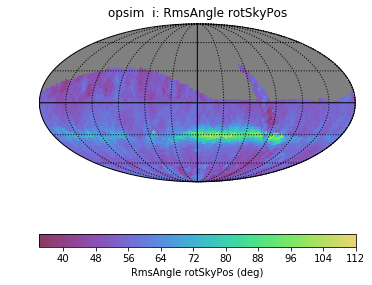

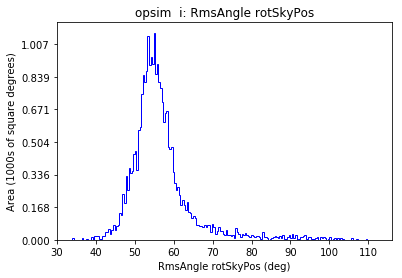

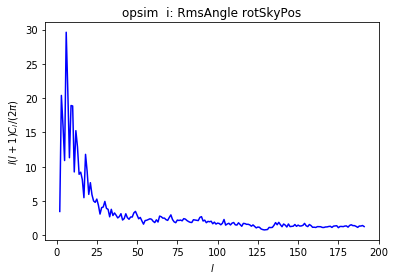

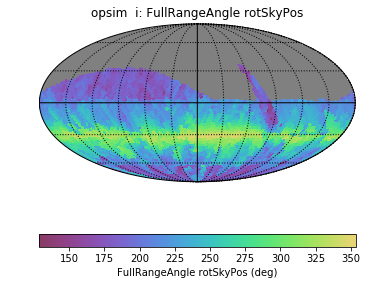

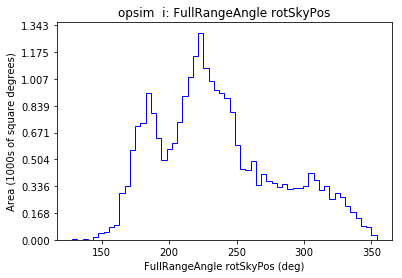

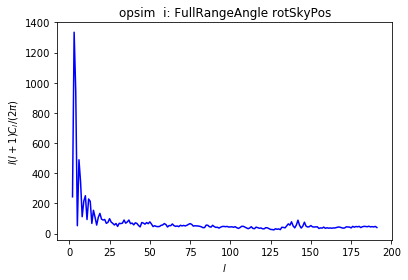

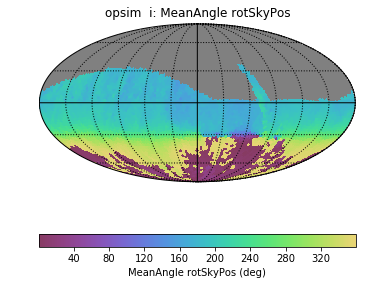

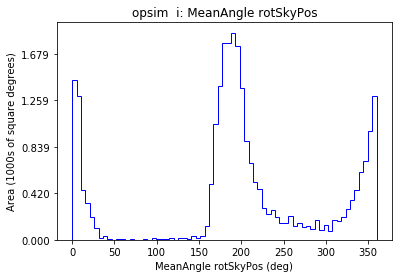

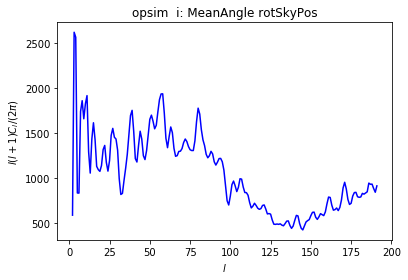

In [10]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [17]:
bundleList = []
stacker = RandRotSkyPos()

metric = metrics.RmsAngleMetric(col='rotTelPos')
slicer = slicers.HealpixSlicer(nside=64)
sql = 'filter ="i"'

bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotTelPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))

metric=metrics.MeanAngleMetric(col='rotTelPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter ="i" for columns ['observationStartLST', 'fieldRA', 'rotTelPos', 'observationStartMJD', 'night', 'fieldDec']
Found 505407 visits
Running:  ['opsim_RmsAngle_rotTelPos_i_HEAL', 'opsim_FullRangeAngle_rotTelPos_i_HEAL', 'opsim_MeanAngle_rotTelPos_i_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:119: UserWarning: Warning - column rotTelPos already present in simData, may be overwritten (depending on stacker).
  % (col))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="i"" constraint now.
monopole: 51.318  dipole: lon: -96.4782, lat: 12.2555, amp: 1.48816
monopole: 173.874  dipole: lon: -173.455, lat: -76.0619, amp: 1.20439
monopole: 219.825  dipole: lon: -83.4777, lat: 46.4242, amp: 87.6406
Plotting complete.


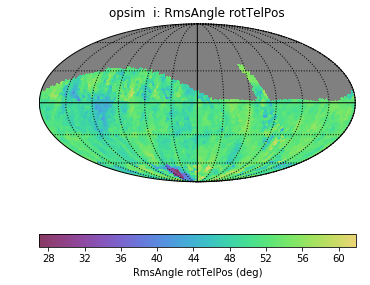

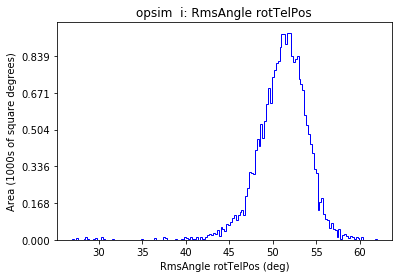

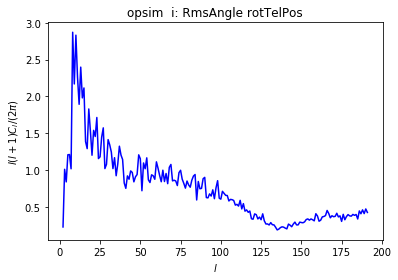

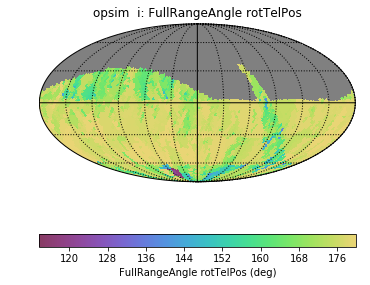

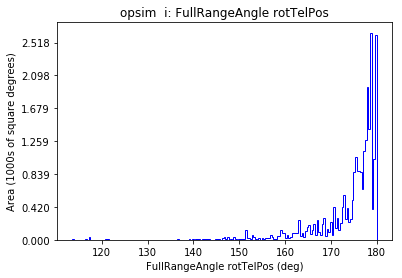

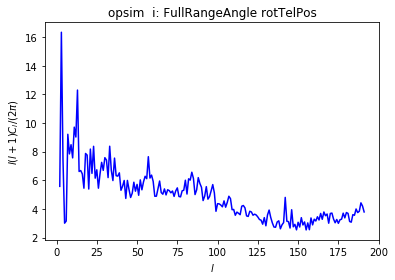

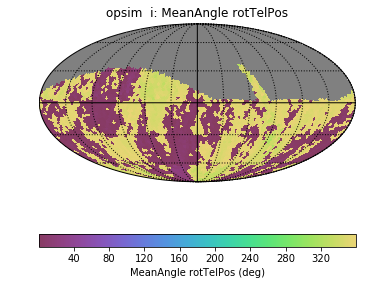

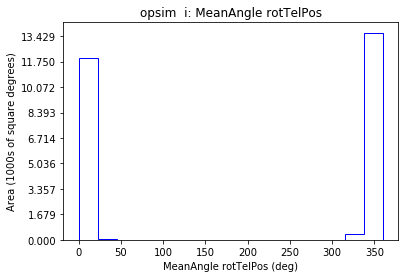

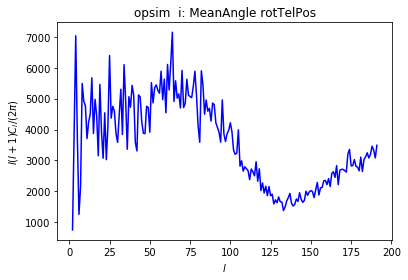

In [18]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)